In [14]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import re
import glob
import time
import itertools
from multiprocessing import Pool
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [66]:
data = pd.read_csv('data.csv')
data.head().transpose()

,0,1,2,3,4
filename,blues.00081.au,blues.00022.au,blues.00031.au,blues.00012.au,blues.00056.au
tempo,103.359,95.7031,151.999,184.57,161.499
beats,50,44,75,91,74
chroma_stft,0.38026,0.306451,0.253487,0.26932,0.391059
rmse,0.248262,0.113475,0.151571,0.119072,0.137728
spectral_centroid,2116.94,1156.07,1331.07,1361.05,1811.08
spectral_bandwidth,1956.61,1497.67,1973.64,1567.8,2052.33
rolloff,4196.11,2170.05,2900.17,2739.63,3927.81
zero_crossing_rate,0.127272,0.0586134,0.0429672,0.0691239,0.0754795
mfcc1,-26.9298,-233.861,-221.803,-207.208,-145.435


(array([  8.,  53., 202., 289., 239., 127.,  49.,  27.,   4.,   2.]),
 array([ 18. ,  27.9,  37.8,  47.7,  57.6,  67.5,  77.4,  87.3,  97.2,
        107.1, 117. ]),
 <a list of 10 Patch objects>)

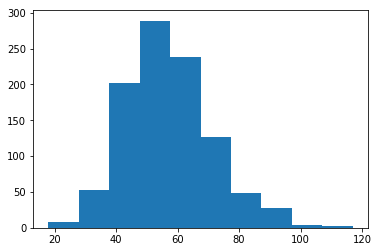

In [3]:
plt.hist(data['beats'], bins=10)

In [4]:
genres = sorted(set(data['label']))

In [5]:
def genre_to_onehot(genre):
    array = np.zeros(len(genres), dtype=np.float32)
    array[genre_to_int(genre)] = 1
    return array

In [6]:
def genre_to_int(genre):
    return genres.index(genre)

In [7]:
data['one_hot_label'] = data.apply(lambda row: genre_to_onehot(row['label']), axis=1)
data.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,one_hot_label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [210]:
min_max_scaler = preprocessing.MinMaxScaler()

x_columns = ['tempo', 'beats', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
             'mfcc1', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']

x_train, x_test, y_train_labels, y_test_labels = train_test_split(data[x_columns], data[['label']], stratify=data[['label']], test_size=0.30)

x_train = min_max_scaler.fit_transform(x_train.to_numpy())
x_test = min_max_scaler.fit_transform(x_test.to_numpy())

In [211]:
x_train.shape

(700, 18)

In [212]:
x_test.shape

(300, 18)

In [213]:
x_test

array([[0.53763441, 0.51807229, 0.04517555, ..., 0.30385681, 0.48786624,
        0.64345404],
       [0.20737327, 0.19277108, 0.3011973 , ..., 0.70294587, 0.25627131,
        0.47672067],
       [0.53763441, 0.53012048, 0.42925203, ..., 0.47589884, 0.42585047,
        0.49616022],
       ...,
       [0.05093379, 0.09638554, 0.32372437, ..., 0.44853202, 0.51342866,
        0.55314529],
       [0.40552995, 0.42168675, 0.59942295, ..., 0.54427879, 0.50430884,
        0.4517645 ],
       [0.80184332, 0.77108434, 0.04887728, ..., 0.42151546, 0.49339823,
        0.58370579]])

In [214]:
y_test = []

#print(y_test_labels)
for index, row in y_test_labels.iterrows():
    y_test.append(genre_to_onehot(row['label']))
    
y_test = np.array(y_test)

y_train = []

#print(y_test_labels)
for index, row in y_train_labels.iterrows():
    y_train.append(genre_to_onehot(row['label']))
    
y_train = np.array(y_train)

In [215]:
pca = PCA(n_components=16)
pca.fit(x_train)
pca_x_train = min_max_scaler.fit_transform(pca.transform(x_train))

pca.fit(x_test)
pca_x_test = min_max_scaler.fit_transform(pca.transform(x_test))

In [216]:
pca_x_train

array([[0.3024682 , 0.25876748, 0.2128851 , ..., 0.49951429, 0.28096705,
        0.12466419],
       [0.75378849, 0.53100958, 0.37499991, ..., 0.4886887 , 0.45926606,
        0.05386402],
       [0.30690673, 0.32574984, 0.38386785, ..., 0.43892745, 0.15660479,
        0.14382367],
       ...,
       [0.09851521, 0.11507983, 0.50475039, ..., 0.3579417 , 0.45739718,
        0.12639108],
       [0.52444295, 0.57156332, 0.54852558, ..., 0.39565262, 0.38532158,
        0.09961096],
       [0.12474222, 0.14831601, 0.50952864, ..., 0.31390488, 0.45354919,
        0.17521592]])

In [217]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(tf.keras.layers.Dense(14, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [218]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [219]:
history = model.fit(x_train, y_train, epochs=400, batch_size=64, validation_split=0.1)

Train on 630 samples, validate on 70 samples
Epoch 1/400
630/630 [==============================] - 2s 3ms/sample - loss: 2.3172 - acc: 0.1238 - val_loss: 2.3071 - val_acc: 0.1143
Epoch 2/400
630/630 [==============================] - 0s 208us/sample - loss: 2.3062 - acc: 0.1000 - val_loss: 2.2984 - val_acc: 0.1429
Epoch 3/400
630/630 [==============================] - 0s 114us/sample - loss: 2.2985 - acc: 0.1270 - val_loss: 2.2927 - val_acc: 0.1429
Epoch 4/400
630/630 [==============================] - 0s 78us/sample - loss: 2.2886 - acc: 0.1317 - val_loss: 2.2871 - val_acc: 0.1143
Epoch 5/400
630/630 [==============================] - 0s 66us/sample - loss: 2.2853 - acc: 0.1317 - val_loss: 2.2772 - val_acc: 0.1571
Epoch 6/400
630/630 [==============================] - 0s 69us/sample - loss: 2.2739 - acc: 0.1524 - val_loss: 2.2659 - val_acc: 0.1714
Epoch 7/400
630/630 [==============================] - 0s 99us/sample - loss: 2.2647 - acc: 0.1841 - val_loss: 2.2530 - val_acc: 0.2286
Ep

In [220]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.46666667


Text(0, 0.5, 'loss')

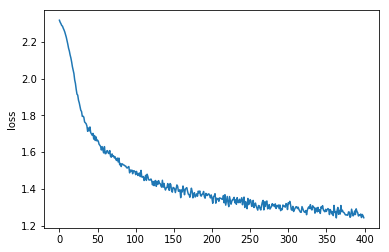

In [221]:
plt.plot(history.history['loss'])
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

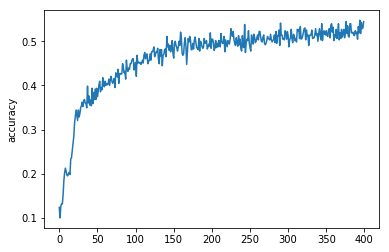

In [222]:
plt.plot(history.history['acc'])
plt.ylabel('accuracy')